In [45]:
import pandas as pd
import urllib.request
import os
from datetime import datetime,date
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import json
import yaml
from calendar import monthrange
import xarray as xr
import cdsapi
import zipfile
from glob import glob

#### IMPORTANT ############
#before running this script, go to cads_forms_json, git pull, then git checkout prod
###########################

# general recipe taken from https://www.datacamp.com/tutorial/how-to-make-gantt-chart-in-python-matplotlib

def calculate_bars(timeseries,dates):
    sdates = []
    edates = []
    durations = []
    
    isBar = False # no bar by default at beginning
    for i in range(len(timeseries)-1): # note the -1, last date is treated explicitly below
        if (timeseries[i] == 1) and not isBar: #beginning of bar
            startdate = i
            isBar = True
        elif (timeseries[i] == 0) and isBar: # end of bar
            enddate = i-1
            duration = enddate-startdate+1
            sdates.append(startdate)
            edates.append(enddate)
            durations.append(duration)
            isBar = False
    i=len(timeseries)-1 # last element/date. need to close any pending bar (or create a new one)
    if isBar and (timeseries[i] == 1): # 11 bar closes at last month
        enddate=i
        duration = enddate-startdate+1
        sdates.append(startdate)
        edates.append(enddate)
        durations.append(duration)
    elif not isBar and (timeseries[i] == 1): #01 - bar with only one month
        startdate=i
        enddate=i
        duration = enddate-startdate+1
        sdates.append(startdate)
        edates.append(enddate)
        durations.append(duration)
    elif isBar and (timeseries[i] == 0): #10 bar closes at the previous month
        enddate=i-1
        duration = enddate-startdate+1
        sdates.append(startdate)
        edates.append(enddate)
        durations.append(duration)
    else: # 00 - there was no open bar, nothing needs to be done
        pass
    
    return sdates,edates,durations
def plot_soil_moisture_coverage():
    
    ecv=conf['PRODUCT']['Soil Moisture']
    entry = ecv['entry'][0] # mind cases of multiple entries -- to do
    # print(entry)
    jfilepath=f'{cds_form_dir}{entry}/constraints.json'
    print(jfilepath)
    
    dates = pd.date_range(start='1970-01-01',end=pd.Timestamp.today(),freq='MS')

    #Opening JSON file
    f = open(jfilepath)
    # returns JSON object as # a dictionary
    data = json.load(f)
    df = pd.DataFrame(data)

    coverage ={}
    for index,row in df.iterrows():
        
        #if combination sensor - version does not exist, create entry in dic
        # cdr and icdr info are stored separately for each version
        # we need these loops because type_of_sensor might not be unique for each row
        for typeSensor in row['type_of_sensor']:
            for version in row['version']:
                sensversion = typeSensor+'_'+version
                if sensversion not in coverage:
                    print(sensversion+ ' entry created...')
                    coverage[sensversion] = {
                        'cdr' : np.zeros(len(dates)).astype(int),
                        'icdr' : np.zeros(len(dates)).astype(int),
                    }
                # now for each entry create a list of possible dates
                list_dates = [pd.Timestamp(int(yy),int(mm),1) for yy in row['year'] for mm in row['month']]
                for typrecord in row['type_of_record']:
                    coverage[sensversion][typrecord][dates.isin(list_dates)]=1

    # now build the pd dataframe for the final bars

    barsList = []
    for k in coverage.keys(): # iterate on sensversion
        datarec = coverage[k]
        # print(k,datarec)
        for typRec in datarec.keys(): # cdr,icdr
            
            sdates,edates,durations = calculate_bars(datarec[typRec],dates)
            for item in k.split('_'):
                if item[0]=='v': version=item
            sensor=k.split('_')[0]
            if sensor=='combined': sensor='combined_passive_and_active'
            
            # print(datarec[typRec])
            # print(k,typRec,dates[sdates],dates[edates],durations)
            for i in range(len(sdates)):
                barsList.append([k,sensor,version,typRec,sdates[i],edates[i],durations[i]])
    dfBars = pd.DataFrame(barsList,columns=['sensversion','sensor','version','typRec','sdate','edate','duration'])
    dfBars = dfBars.sort_values(by=['sensor','version'])

    rec_alpha={'cdr':1,'icdr':0.5}
    sensor_color={
        'active':'r',
        'passive': 'b',
        'combined_passive_and_active': 'g',
    }

    def get_ylabels(lables):
        ylabels=[]
        for label in lables:
            if 'active' in label.split('_')[0]:
                ylabels.append(label[7::])
            elif 'passive' in label.split('_')[0]:
                ylabels.append(label[8::])
            elif 'combined' in label.split('_')[0]:
                ylabels.append(label[28::])
            else:
                print('unknown ylabel...')
        return ylabels

    # dfBars['ylabels'] = dfBars.apply(get_ylabels,axis=1)        
    plt.close('all')
    fig, ax = plt.subplots(figsize=(9.2, 7))
    ax.invert_yaxis()

    for index, row in dfBars.iterrows():
        # ax.barh(y=row['sensversion'],width=row['duration'],left=row['sdate'],color=rec_colors[row['typRec']])
        label =row['sensor']
        if label=='combined_passive_and_active': label='combined'
        ax.barh(
            y=row['sensversion'],
            width=row['duration'],
            left=row['sdate'],
            color=sensor_color[row['sensor']],
            alpha=rec_alpha[row['typRec']],
            label=label+'/'+row['typRec'],
            # tick_label=row['ylabels'] 
            )
    ax.set_xticks(np.arange(0,len(dates)+12,12))
    xticklabels = np.arange(dates.min().year,dates.max().year+2)
    ax.set_xticklabels(xticklabels,fontsize=6,rotation=45)
    ax.grid(True,which='major',axis='y', linestyle='--') 
    labels = [item.get_text() for item in ax.get_yticklabels()]
    ylables = get_ylabels(labels)
    ax.set_yticklabels(ylables)
    # ax.set_yticks(range(len(ylabels)),ylabels)

    plt.yticks(fontsize=6)
    plt.title(f'{product} Time Coverage')
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(),title='Sensor Type/record type')
    now = pd.Timestamp.now()
    nowstr=now.strftime('%Y%m%d')
    plt.axvline(x=len(dates),color='k',ls='--',lw=1)
    plt.tight_layout()
    plt.savefig(conf['figs_dir']+f'coverage_SoilMoisture_{nowstr}.png',bbox_inches='tight',dpi=150)
    plt.show()
    return
def plot_SeaIceConcentration():

    product='Sea Ice Concentration'
    ecv=conf['PRODUCT'][product]
    entry = ecv['entry'][0] # mind cases of multiple entries -- to do
    # print(entry)
    jfilepath=f'{cds_form_dir}{entry}/constraints.json'
    # print(jfilepath)
    
    dates = pd.date_range(start='1970-01-01',end=pd.Timestamp.today(),freq='MS')

    #Opening JSON file
    f = open(jfilepath)
    # returns JSON object as # a dictionary
    data = json.load(f)
    df = pd.DataFrame(data)

    # 'variable' and 'time aggregation' are not treated in any special way
    # if a daily product has a slot in a given month, it is assumed that month is fully covered
    # this could be fine tuned in the future, to account for higher granularity (sub-monthly)

    hemisphere = {'southern_hemisphere':'SH','northern_hemisphere':'NH'}

    coverage ={}
    for index,row in df.iterrows():
        
        #if combination sensor - version does not exist, create entry in dic
        # cdr and icdr info are stored separately for each version
        # we need these loops because type_of_sensor might not be unique for each row
        for typeSensor in row['sensor']:
            for version in row['version']:
                for region in row['region']:
                    sensversion = typeSensor+'_'+version+'_'+hemisphere[region]
                    if sensversion not in coverage:
                        print(sensversion+ ' entry created...')
                        coverage[sensversion] = {
                            'cdr' : np.zeros(len(dates)).astype(int),
                            'icdr' : np.zeros(len(dates)).astype(int),
                        }
                    # now for each entry create a list of possible dates
                    list_dates = [pd.Timestamp(int(yy),int(mm),1) for yy in row['year'] for mm in row['month']]
                    for typrecord in row['cdr_type']:
                        coverage[sensversion][typrecord][dates.isin(list_dates)]=1
                        
    # now build the pd dataframe for the final bars

    barsList = []
    for k in coverage.keys(): # iterate on sensversion
        datarec = coverage[k]
        # print(k,datarec)
        for typRec in datarec.keys(): # cdr,icdr
            
            sdates,edates,durations = calculate_bars(datarec[typRec],dates)
            for item in k.split('_'):
                if item[0]=='v': version=item
            sensor=k.split('_')[0]
            if sensor=='combined': sensor='combined_passive_and_active'
            
            # print(datarec[typRec])
            # print(k,typRec,dates[sdates],dates[edates],durations)
            for i in range(len(sdates)):
                barsList.append([k,sensor,version,typRec,sdates[i],edates[i],durations[i]])
    dfBars = pd.DataFrame(barsList,columns=['sensversion','sensor','version','typRec','sdate','edate','duration'])
    dfBars = dfBars.sort_values(by=['sensor','version'])

    rec_alpha={'cdr':1,'icdr':0.5}
    sensor_color={
        'amsr':'r',
        'ssmis': 'b',
        }

    plt.close('all')
    fig, ax = plt.subplots(figsize=(9.2, 5))
    ax.invert_yaxis()

    for index, row in dfBars.iterrows():
        # ax.barh(y=row['sensversion'],width=row['duration'],left=row['sdate'],color=rec_colors[row['typRec']])
        label =row['sensor']
        ax.barh(
            y=row['sensversion'],
            width=row['duration'],
            left=row['sdate'],
            color=sensor_color[row['sensor']],
            alpha=rec_alpha[row['typRec']],
            label=label+'/'+row['typRec'],
            # tick_label=row['ylabels'] 
            )
    ax.set_xticks(np.arange(0,len(dates)+12,12))
    xticklabels = np.arange(dates.min().year,dates.max().year+2)
    ax.set_xticklabels(xticklabels,fontsize=6,rotation=45)
    ax.grid(True,which='major',axis='y', linestyle='--') 
    labels = [item.get_text() for item in ax.get_yticklabels()]

    plt.yticks(fontsize=6)
    plt.title(f'{product} Time Coverage')
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(),title='Sensor Type/record type')
    now = pd.Timestamp.now()
    nowstr=now.strftime('%Y%m%d')
    plt.axvline(x=len(dates),color='k',ls='--',lw=1)
    plt.tight_layout()
    plt.savefig(conf['figs_dir']+f'coverage_SeaIceConcentration_{nowstr}.png',bbox_inches='tight',dpi=150)
    plt.show()
    return
def plot_aerosols():
    product='Aerosols'
    ecv=conf['PRODUCT'][product]
    entry = ecv['entry'][0] # mind cases of multiple entries -- to do
    # print(entry)
    jfilepath=f'{cds_form_dir}{entry}/constraints.json'
    print(jfilepath)
    
    dates = pd.date_range(start='1982-01-01',end=pd.Timestamp.today(),freq='MS')

    #Opening JSON file
    f = open(jfilepath)
    # returns JSON object as # a dictionary
    data = json.load(f)
    df = pd.DataFrame(data)

    # 'variable' and 'time aggregation' are not treated in any special way
    # if a daily product has a slot in a given month, it is assumed that month is fully covered
    # this could be fine tuned in the future, to account for higher granularity (sub-monthly)

    coverage ={}
    for index,row in df.iterrows():
        
        #if combination sensor - version does not exist, create entry in dic
        # cdr and icdr info are stored separately for each version
        # we need these loops because type_of_sensor might not be unique for each row
        for typeSensor in row['sensor_on_satellite']:
            for algorithm in row['algorithm']:
                for version in row['version']:
                    sensversion = typeSensor+' '+algorithm+' '+version
                    if sensversion not in coverage:
                        print(sensversion+ ' entry created...')
                        coverage[sensversion] = {
                            'cdr' : np.zeros(len(dates)).astype(int),
                            'icdr' : np.zeros(len(dates)).astype(int),
                        }
                    # now for each entry create a list of possible dates
                    list_dates = [pd.Timestamp(int(yy),int(mm),1) for yy in row['year'] for mm in row['month']]
                    if 'cdr_type' in row.keys():
                        for typrecord in row['cdr_type']:
                            coverage[sensversion][typrecord][dates.isin(list_dates)]=1
                    else:
                        coverage[sensversion]['cdr'][dates.isin(list_dates)]=1 # by default only use the CDR category
                        
    # now build the pd dataframe for the final bars

    barsList = []
    for k in coverage.keys(): # iterate on sensversion

        datarec = coverage[k]
        # print(k,datarec)
        for typRec in datarec.keys(): # cdr,icdr
            
            sdates,edates,durations = calculate_bars(datarec[typRec],dates)
            sensor=k.split(' ')[0]
            algorithm=k.split(' ')[1]
            version=k.split(' ')[2]
            # print(datarec[typRec])
            # print(k,typRec,dates[sdates],dates[edates],durations)
            for i in range(len(sdates)):
                barsList.append([k,sensor,algorithm,version,typRec,sdates[i],edates[i],durations[i]])
    dfBars = pd.DataFrame(barsList,columns=['sensversion','sensor','algorithm','version','typRec','sdate','edate','duration'])
    dfBars = dfBars.sort_values(by=['algorithm','version'])
    dfBars['sensor'] = dfBars['sensor'].str.upper()
    print(dfBars['sensor'].unique())
    rec_alpha={'cdr':1,'icdr':0.5}
    # color each sensor differently
    l = list(dfBars['sensor'].unique())
    cmap = plt.cm.tab20(range(dfBars["sensor"].unique().shape[0]))
    cvalue = {l[i]: cmap[i] for i in range(len(l))}

    plt.close('all')
    # fig, ax = plt.subplots(figsize=(8, 12))
    fig, ax = plt.subplots(figsize=(10, 12))
    ax.invert_yaxis()

    for index, row in dfBars.iterrows():
        # ax.barh(y=row['sensversion'],width=row['duration'],left=row['sdate'],color=rec_colors[row['typRec']])
        label =row['sensor']
        ax.barh(
            y=row['sensversion'],
            width=row['duration'],
            left=row['sdate'],
            color=cvalue[row['sensor']],
            alpha=rec_alpha[row['typRec']],
            label=label,
            # label=label+'/'+row['typRec'],
            # tick_label=row['ylabels'] 
            )
    ax.set_xticks(np.arange(0,len(dates)+12,12))
    xticklabels = np.arange(dates.min().year,dates.max().year+2)
    ax.set_xticklabels(xticklabels,fontsize=6,rotation=45)
    ax.grid(True,which='major',axis='y', linestyle='--') 
    labels = [item.get_text() for item in ax.get_yticklabels()]

    plt.yticks(fontsize=6)
    plt.title(f'{product} Time Coverage')
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    # plt.legend(by_label.values(), by_label.keys(),title='Sensor Type/record type')
    plt.legend(by_label.values(), by_label.keys(),title='Sensor')
    now = pd.Timestamp.now()
    nowstr=now.strftime('%Y%m%d')
    plt.axvline(x=len(dates),color='k',ls='--',lw=1)
    plt.tight_layout()
    plt.savefig(conf['figs_dir']+f'coverage_{product}_{nowstr}.png',bbox_inches='tight',dpi=150)
    plt.show()
def plot_OceanColour():
    dates = pd.date_range(start='1997-01-01',end=pd.Timestamp.today(),freq='MS')
    # dates = pd.date_range(start='1982-01-01',end=pd.Timestamp.today(),freq='MS')

    product='Ocean Colour'
    ecv=conf['PRODUCT'][product]
    entry = ecv['entry'][0] # mind cases of multiple entries -- to do
    # print(entry)
    jfilepath=f'{cds_form_dir}{entry}/constraints.json'
    print(jfilepath)

    #Opening JSON file
    f = open(jfilepath)
    # returns JSON object as # a dictionary
    data = json.load(f)
    df = pd.DataFrame(data)

    # 'variable' and 'time aggregation' are not treated in any special way
    # if a daily product has a slot in a given month, it is assumed that month is fully covered
    # this could be fine tuned in the future, to account for higher granularity (sub-monthly)

    coverage ={}
    for index,row in df.iterrows():
        #if combination sensor - version does not exist, create entry in dic
        # cdr and icdr info are stored separately for each version
        # we need these loops because type_of_sensor might not be unique for each row
        # for typeSensor in row['sensor_on_satellite']:
        for version in row['version']:
            sensversion = version
            if sensversion not in coverage:
                print(sensversion+ ' entry created...')
                coverage[sensversion] = {
                    'cdr' : np.zeros(len(dates)).astype(int),
                    # 'icdr' : np.zeros(len(dates)).astype(int),
                }
            # now for each entry create a list of possible dates
            list_dates = [pd.Timestamp(int(yy),int(mm),1) for yy in row['year'] for mm in row['month']]
            if 'cdr_type' in row.keys():
                for typrecord in row['cdr_type']:
                    coverage[sensversion][typrecord][dates.isin(list_dates)]=1
            else:
                coverage[sensversion]['cdr'][dates.isin(list_dates)]=1 # by default only use the CDR category
            
    # now build the pd dataframe for the final bars

    barsList = []
    for k in coverage.keys(): # iterate on sensversion

        datarec = coverage[k]
        # print(k,datarec)
        for typRec in datarec.keys(): # cdr,icdr
            
            sdates,edates,durations = calculate_bars(datarec[typRec],dates)
            # sensor=k.split(' ')[0]
            # algorithm=k.split(' ')[1]
            # version=k.split(' ')[2]
            version=k
            # print(datarec[typRec])
            # print(k,typRec,dates[sdates],dates[edates],durations)
            for i in range(len(sdates)):
                # barsList.append([k,sensor,algorithm,version,typRec,sdates[i],edates[i],durations[i]])
                barsList.append([version,typRec,sdates[i],edates[i],durations[i]])
    # dfBars = pd.DataFrame(barsList,columns=['sensversion','sensor','algorithm','version','typRec','sdate','edate','duration'])
    dfBars = pd.DataFrame(barsList,columns=['version','typRec','sdate','edate','duration'])

    # dfBars = dfBars.sort_values(by=['projection','version'])
    # dfBars['variable'] = dfBars['variable'].str.upper()
    # print(dfBars['variable'].unique())
    rec_alpha={'cdr':1,'icdr':0.5}
    # color each variable differently
    l = list(dfBars['version'].unique())
    # for i in range(len(l)):
    #     l[i]=l[i].replace('_','.')
    print(dfBars["version"])
    cmap = plt.cm.tab10(range(dfBars["version"].unique().shape[0]))
    cvalue = {l[i]: cmap[i] for i in range(len(l))}


    plt.close('all')
    # fig, ax = plt.subplots(figsize=(8, 12))
    fig, ax = plt.subplots(figsize=(8,4))
    ax.invert_yaxis()

    for index, row in dfBars.iterrows():
        # ax.barh(y=row['sensversion'],width=row['duration'],left=row['sdate'],color=rec_colors[row['typRec']])
        label =row['version'].replace('_','.')
        ax.barh(
            y=row['version'],
            width=row['duration'],
            left=row['sdate'],
            color=cvalue[row['version']],
            alpha=rec_alpha[row['typRec']],
            label=label,
            # label=label+'/'+row['typRec'],
            # tick_label=row['ylabels'] 
            )
    ax.set_xticks(np.arange(0,len(dates)+12,12))
    xticklabels = np.arange(dates.min().year,dates.max().year+2)
    ax.set_xticklabels(xticklabels,fontsize=6,rotation=45)
    ax.grid(True,which='major',axis='y', linestyle='--') 
    labels = [item.get_text() for item in ax.get_yticklabels()]

    plt.yticks(fontsize=6)
    plt.title(f'{product} Time Coverage')
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    # plt.legend(by_label.values(), by_label.keys(),title='Sensor Type/record type')
    plt.legend(by_label.values(), by_label.keys(),title='version')
    now = pd.Timestamp.now()
    nowstr=now.strftime('%Y%m%d')
    plt.axvline(x=len(dates),color='k',ls='--',lw=1)
    plt.tight_layout()
    plt.savefig(conf['figs_dir']+f'coverage_{product}_{nowstr}.png',bbox_inches='tight',dpi=150)
    plt.show()
    return
def plot_SeaIceEdgeandType():
    product='Sea Ice Edge and Type'
    ecv=conf['PRODUCT'][product]
    entry = ecv['entry'][0] # mind cases of multiple entries -- to do
    # print(entry)
    jfilepath=f'{cds_form_dir}{entry}/constraints.json'

    dates = pd.date_range(start='1970-01-01',end=pd.Timestamp.today(),freq='MS')

    #Opening JSON file
    f = open(jfilepath)
    # returns JSON object as # a dictionary
    data = json.load(f)
    df = pd.DataFrame(data)

    # 'variable' and 'time aggregation' are not treated in any special way
    # if a daily product has a slot in a given month, it is assumed that month is fully covered
    # this could be fine tuned in the future, to account for higher granularity (sub-monthly)

    hemisphere = {'southern_hemisphere':'SH','northern_hemisphere':'NH'}

    coverage ={}
    for index,row in df.iterrows():
        
        #if combination sensor - version does not exist, create entry in dic
        # cdr and icdr info are stored separately for each version
        # we need these loops because type_of_sensor might not be unique for each row
        for variable in row['variable']:
            for version in row['version']:
                for region in row['region']:
                    sensversion = variable+"_"+hemisphere[region]+'.'+version
                    if sensversion not in coverage:
                        print(sensversion+ ' entry created...')
                        coverage[sensversion] = {
                            'cdr' : np.zeros(len(dates)).astype(int),
                            'icdr' : np.zeros(len(dates)).astype(int),
                        }
                    # now for each entry create a list of possible dates
                    list_dates = [pd.Timestamp(int(yy),int(mm),1) for yy in row['year'] for mm in row['month']]
                    for typrecord in row['cdr_type']:
                        coverage[sensversion][typrecord][dates.isin(list_dates)]=1
                        
    # now build the pd dataframe for the final bars

    barsList = []
    for k in coverage.keys(): # iterate on sensversion
        datarec = coverage[k]
        # print(k,datarec)
        for typRec in datarec.keys(): # cdr,icdr
            
            sdates,edates,durations = calculate_bars(datarec[typRec],dates)
            for item in k.split('.'):
                if item[0]=='v': version=item
            variable=k.split('.')[0]
            
            # print(datarec[typRec])
            # print(k,typRec,dates[sdates],dates[edates],durations)
            for i in range(len(sdates)):
                barsList.append([k,variable,version,typRec,sdates[i],edates[i],durations[i]])
    dfBars = pd.DataFrame(barsList,columns=['sensversion','variable','version','typRec','sdate','edate','duration'])
    dfBars = dfBars.sort_values(by=['variable','version'])

    rec_alpha={'cdr':1,'icdr':0.5}
    variable_color={
        'sea_ice_edge_SH':'r',
        'sea_ice_edge_NH':'g',
        'sea_ice_type_SH': 'b',
        'sea_ice_type_NH': 'orange',
        }

    plt.close('all')
    fig, ax = plt.subplots(figsize=(9.2, 5))
    ax.invert_yaxis()

    for index, row in dfBars.iterrows():
        # ax.barh(y=row['sensversion'],width=row['duration'],left=row['sdate'],color=rec_colors[row['typRec']])
        label =row['variable']
        ax.barh(
            y=row['sensversion'],
            width=row['duration'],
            left=row['sdate'],
            color=variable_color[row['variable']],
            alpha=rec_alpha[row['typRec']],
            label=label+'/'+row['typRec'],
            # tick_label=row['ylabels'] 
            )
    ax.set_xticks(np.arange(0,len(dates)+12,12))
    xticklabels = np.arange(dates.min().year,dates.max().year+2)
    ax.set_xticklabels(xticklabels,fontsize=6,rotation=45)
    ax.grid(True,which='major',axis='y', linestyle='--') 
    labels = [item.get_text() for item in ax.get_yticklabels()]

    plt.yticks(fontsize=6)
    plt.title(f'{product} Time Coverage')
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(),title='Sensor Type/record type')
    now = pd.Timestamp.now()
    nowstr=now.strftime('%Y%m%d')
    plt.axvline(x=len(dates),color='k',ls='--',lw=1)
    plt.tight_layout()
    plt.savefig(conf['figs_dir']+f'coverage_SeaIceConcentration_{nowstr}.png',bbox_inches='tight',dpi=150)
    plt.show()
    return

with open('config-athos.yml') as f:
    conf= yaml.safe_load(f)
    
cds_form_dir=conf['cds_form_dir']
datasets_dir = conf['datasets_dir']


/home/cxjo/C3S_stuff/cads-forms-json/satellite-soil-moisture/constraints.json
active_v201706 entry created...
combined_passive_and_active_v201706 entry created...
passive_v201706 entry created...
active_deprecated_v201912 entry created...
combined_passive_and_active_deprecated_v201912 entry created...
passive_deprecated_v201912 entry created...
active_v201812 entry created...
active_v202012 entry created...
active_v202212 entry created...
active_v202312 entry created...
combined_passive_and_active_v201812 entry created...
passive_v201812 entry created...
combined_passive_and_active_v202012 entry created...
passive_v202012 entry created...
combined_passive_and_active_v202212 entry created...
passive_v202212 entry created...
combined_passive_and_active_v202312 entry created...
passive_v202312 entry created...
active_v201912_1 entry created...
combined_passive_and_active_v201912_1 entry created...
passive_v201912_1 entry created...


/etc/ecmwf/ssd/ssd1/tmpdirs/cxjo.3114230.20241230_151136.826/ipykernel_3186487/2569521970.py:164: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ylables)


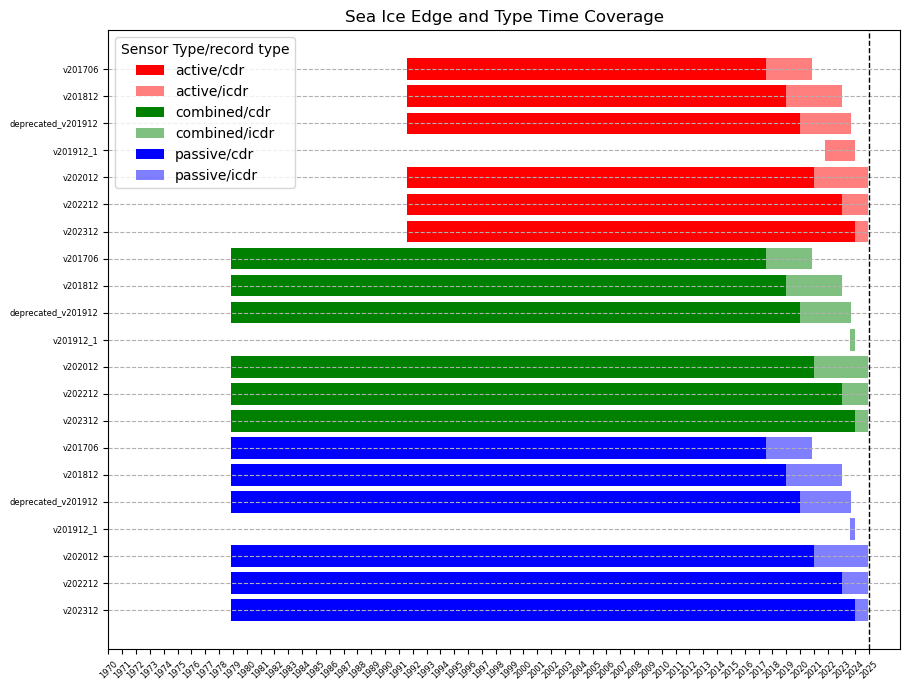

ssmis_v3_NH entry created...
ssmis_v3_SH entry created...
ssmis_v2_NH entry created...
ssmis_v2_SH entry created...
amsr_v2_NH entry created...
amsr_v2_SH entry created...
amsr_v3_NH entry created...
amsr_v3_SH entry created...


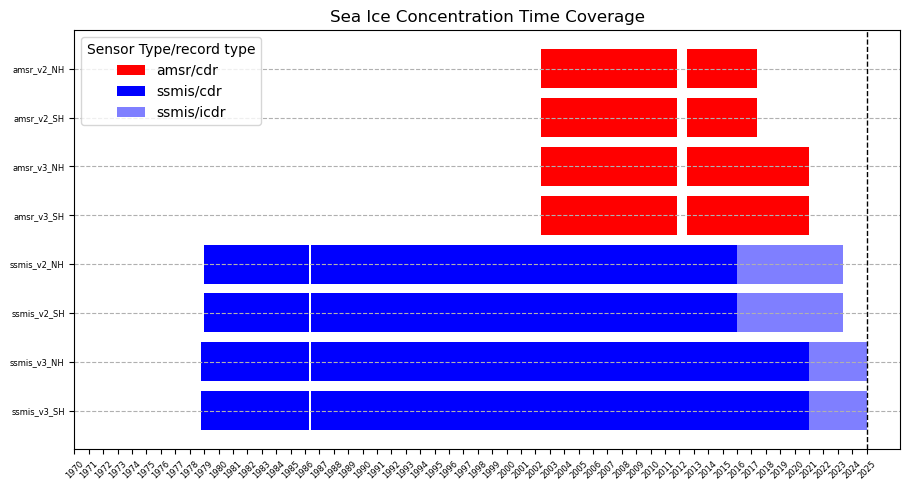

/home/cxjo/C3S_stuff/cads-forms-json/satellite-aerosol-properties/constraints.json
aatsr_on_envisat adv v2_30 entry created...
aatsr_on_envisat adv v3_11 entry created...
aatsr_on_envisat adv v4_0 entry created...
aatsr_on_envisat adv v4_1 entry created...
atsr2_on_ers2 adv v2_30 entry created...
atsr2_on_ers2 adv v4_0 entry created...
atsr2_on_ers2 adv v4_1 entry created...
atsr2_on_ers2 adv v3_11 entry created...
gomos_on_envisat aergom v3_00 entry created...
gomos_on_envisat aergom v4_00 entry created...
gomos_on_envisat aergom v4_01s entry created...
gomos_on_envisat aergom deprecated (v5.00) entry created...
polder_on_parasol grasp v0_08 entry created...
polder_on_parasol grasp v2_01 entry created...
polder_on_parasol grasp v2_10 entry created...
polder_on_parasol grasp v2_20 entry created...
iasi_on_metopa imars v5_2 entry created...
iasi_on_metopa imars v6_0 entry created...
iasi_on_metopa imars v7_0 entry created...
iasi_on_metopa imars v7_1 entry created...
iasi_on_metopc imar

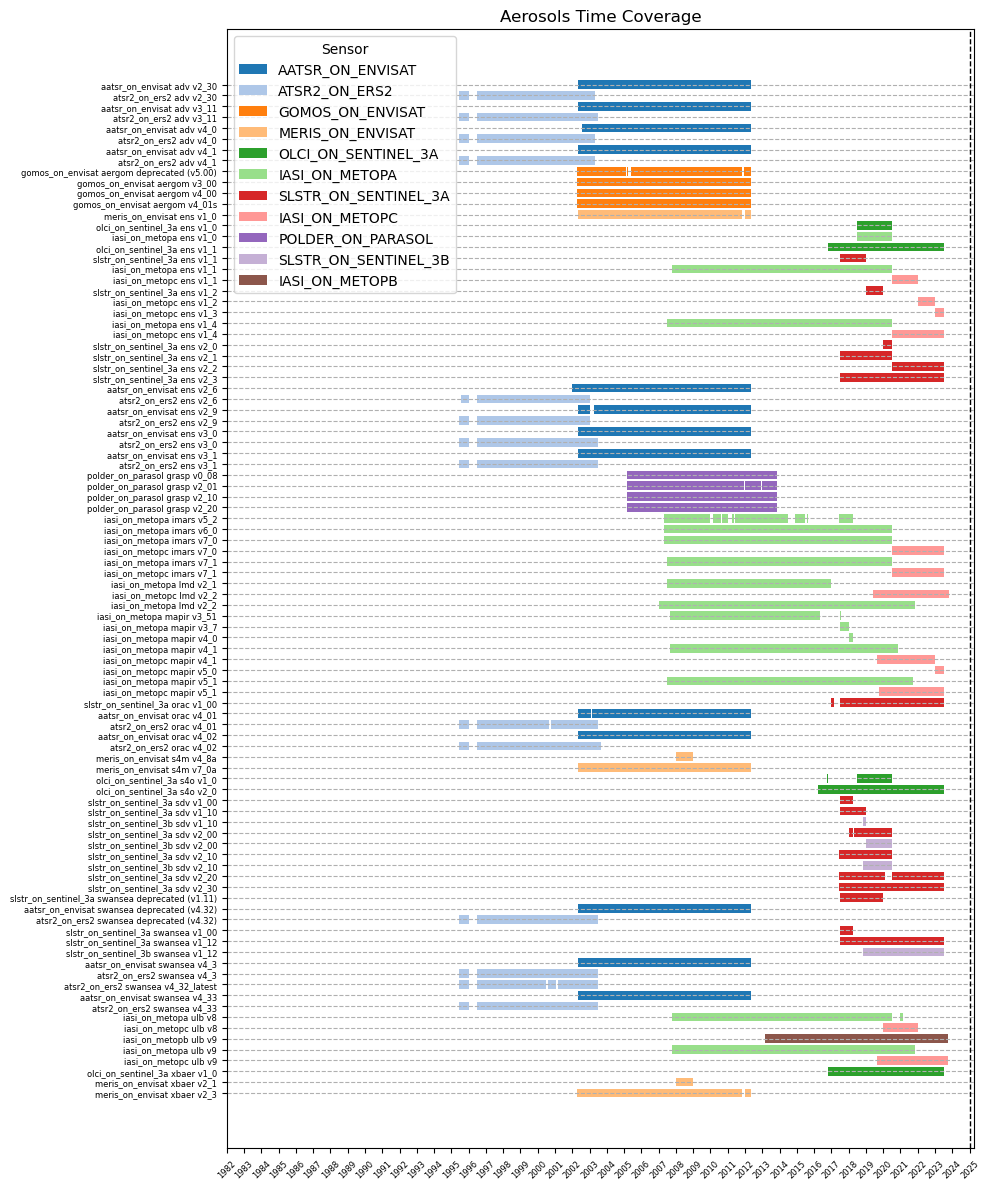

/home/cxjo/C3S_stuff/cads-forms-json/satellite-ocean-colour/constraints.json
5_0 entry created...
5_0_1 entry created...
6_0 entry created...
0      5_0
1    5_0_1
2      6_0
Name: version, dtype: object


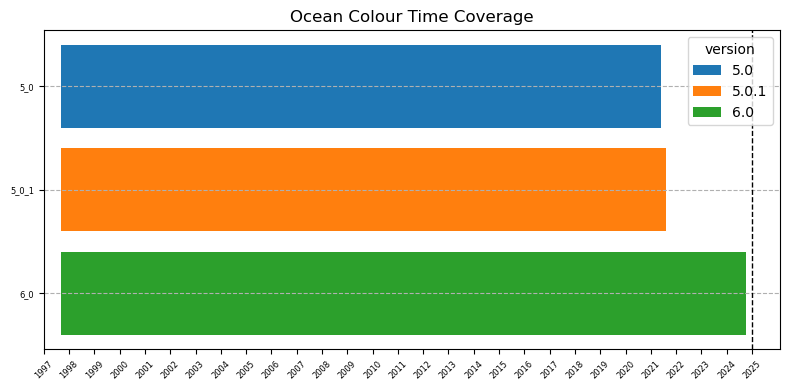

sea_ice_type_NH.1_0 entry created...
sea_ice_type_NH.2_0 entry created...
sea_ice_type_NH.3_0 entry created...
sea_ice_edge_NH.1_0 entry created...
sea_ice_edge_SH.1_0 entry created...
sea_ice_edge_NH.2_0 entry created...
sea_ice_edge_SH.2_0 entry created...
sea_ice_edge_NH.3_0 entry created...
sea_ice_edge_SH.3_0 entry created...


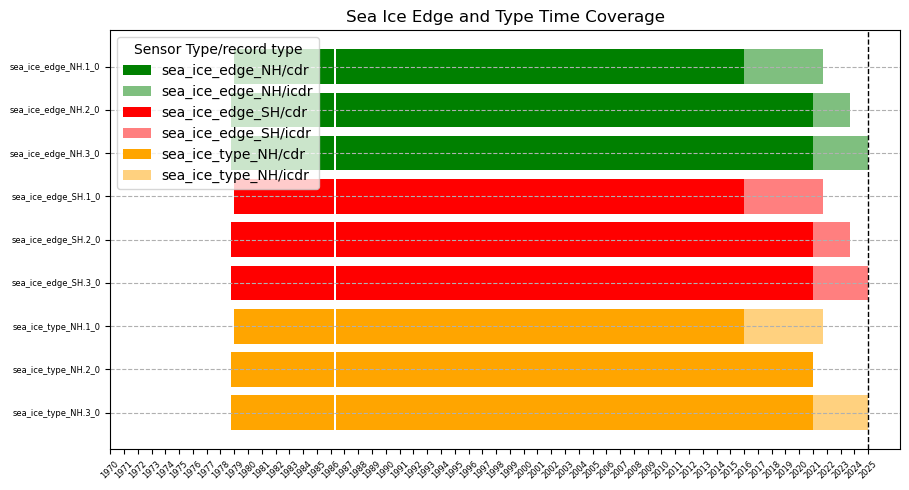

In [46]:
plot_soil_moisture_coverage()
plot_SeaIceConcentration()
plot_aerosols()
plot_OceanColour()
plot_SeaIceEdgeandType()

In [9]:

print(dates)

DatetimeIndex(['1970-01-01', '1970-02-01', '1970-03-01', '1970-04-01',
               '1970-05-01', '1970-06-01', '1970-07-01', '1970-08-01',
               '1970-09-01', '1970-10-01',
               ...
               '2024-03-01', '2024-04-01', '2024-05-01', '2024-06-01',
               '2024-07-01', '2024-08-01', '2024-09-01', '2024-10-01',
               '2024-11-01', '2024-12-01'],
              dtype='datetime64[ns]', length=660, freq='MS')


: 